# Wöhler analyzing tool
Developed by Mustapha Kassem in scope of a master thesis at TU München

## Pylife Woehler-curve evaluation script

### Initialization

In [1]:
import numpy as np
import pandas as pd
import numpy.ma as ma
from scipy import stats, optimize
import mystic as my
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from os import path
import io
import sys, os
import json

sys.path.insert(0, os.path.abspath('..'))

from pylife.materialdata.woehler.fatigue_data import FatigueData
from pylife.materialdata.woehler.woehler_curve_creator import WoehlerCurveCreator
from pylife.materialdata.woehler.probability_plot_creator import ProbabilityPlotCreator
from pylife.materialdata.woehler.plot_woehler_curve_data import PlotWoehlerCurveData
from pylife.materialdata.woehler.widgets import WoehlerWidget

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
import pdb

### Data import
#### Data is made up of two columns:
 * The first column is made up of the load values
 * The scond column is made up of the load-cycle values
 

In [3]:
file_name = 'woehler-test-data.csv'

##### Transforming data in excel to python arrays

In [4]:
data = pd.read_csv(file_name, sep='\t')
data.columns=['loads', 'cycles']

##### For automization purposes
data = pd.read_excel('../data/Test_dat.xlsx')
data.columns=['loads', 'cycles']

In [5]:
w = WoehlerWidget.data_head_tail()
print('Choose whether to visualize the head or tail of the data found in excel:')
w

Choose whether to visualize the head or tail of the data found in excel:


RadioButtons(description='Visualization:', options=('Head of the data', 'Details of the data'), style=Descript…

##### Visualization of the data:
* It is possible to go back and pick the other choice 
* Rerun this cell to see it

In [6]:
if w.value == 'Head of the data':
    display(data.head())
else: 
    display(data.describe())

,loads,cycles
0,284.39285,1369000
1,284.39285,10000000
2,284.39285,10000000
3,284.39285,10000000
4,284.39285,10000000


#### 2. Enter the load cycle limit (The load-cycle value that seperates Fractures from Run-outs):
##### Note: in case the load cycle limit is the highest number found in the column set it to *max(data[:,1])*

In [7]:
ld_cyc_lim = data['cycles'].max()
#ld_cyc_lim = 10e6

## Parameters

#### 3. Fill in the fixed parameter values. 
#### The empty parameters are the ones to be estimated.
##### Note: don't rerun the cell after typing the values

In [8]:
tab = WoehlerWidget.WL_param()
display(tab)

In [9]:
fixed_param, estim_param =  WoehlerWidget.WL_param_display(tab)

Maximum Likelihood Method:

Estimated Parameters:
k_1
1/TN
SD_50
1/TS
ND_50

Fixed Parameters:


#### 4. Variable definition of class WoehlerCurve: (Variable name = WC_data)

In [10]:
warnings.filterwarnings('ignore')
#pdb.set_trace()
fatigue_data = FatigueData(data, ld_cyc_lim)
woehler_curve_creator = WoehlerCurveCreator(fatigue_data)
woehler_curve = woehler_curve_creator.maximum_like_procedure(fixed_param)

Optimization terminated successfully.
         Current function value: 18.908399
         Iterations: 514
         Function evaluations: 728


#### 5. Paramter results of the chosen evaluation method
##### Colored parameters: estimated
##### Black/white paramters: fixed

In [11]:
estim_param.update(woehler_curve.curve_parameters)
all(map(estim_param.pop, fixed_param))

WoehlerWidget.print_mali_5p_result(woehler_curve, fixed_param)

Maximum Likelihood 5 Param method:

Endurance SD50 = 293.5
Endurance load-cycle ND50 = 1.40e+06
Deviation in load direction 1/TS = 1.11
Slope k = 8.66
Deviation in load-cycle direction 1/TN = 9.86


| Variables              || Explanation                                          |
| :-------------         ||:-------------                                        |
| `fixed_param`          || Fixed parameters (by user)                           |
| `estim_param`          || Estimated parameters (exluding the fixed parameters) |
|`WC_data.Mali_5p_result`|| Estimated & fixed parameters                         |
|`WC_data.Mali_2p_result`|| MLE likelihood functions for the infinite-life zone  |
|`WC_data.k`             || Basquin slope using linear regression                |
|`WC_data.TN`            || Scatter in load-cycle direction using pearl-chain    |
|`WC_data.TS`            || Scatter in load direction using Koeder formula       |
|`WC_data.Probit_result` || Probit parameter results                             |


## Visualization of Results
#### 5. Enter necessary description to personalize the diagram:
 * For a default diagram description set the value default = 1
 * Enter the units for the axes as a string variable [amp, ld_typ, unit]

##### x- and y-axis are dynamically scaled to fit the data in a diagram. If the User wishes to change them:
 * Enter the limits for the x- and y-axis [xlim_WL and ylim_WL]
 <br>
(example: xlim_WL = (4E5, 8E10) )

In [12]:
default = 0

if default == 0:
    amp = 'Amplitude'
    ld_typ = 'Stress'
    unit = u'$N/mm^2$'
    xlim_WL = (round(min(woehler_curve.fatigue_data.data.cycles)*0.4,-1), round(max(woehler_curve.fatigue_data.data.cycles)*2,-1))
    ylim_WL = (round(min(woehler_curve.fatigue_data.data.loads)*0.8,-1), round(max(woehler_curve.fatigue_data.data.loads)*1.2,-1))
else:
    amp, ld_typ, unit, xlim_WL, ylim_WL = 0,0,0,0,0

#### 6. Choose the plot type to be visualized in the following cell

In [13]:
w4 = WoehlerWidget.results_visual_woehler_curve()
print('Choose a plot type and execute the following cell to visualize the results:')
w4

Choose a plot type and execute the following cell to visualize the results:


RadioButtons(description='Plot Type', options=(('Initial data', 'Initial data'), ('Slope', 'Slope'), ('Pearl c…

##### Note: It is possible to go back and pick another choice. Rerun the following cell to see it.

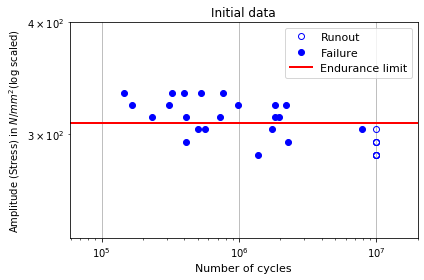

In [14]:
PlotWC = PlotWoehlerCurveData(woehler_curve)
fig, ax = plt.subplots()

ax.set_title('Initial data')
ax.set_xlim(xlim_WL)
ax.set_ylim(ylim_WL)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of cycles', fontsize = 11)
ax.set_ylabel(amp + ' (' + ld_typ+') in ' + unit + '(log scaled)')
#ax.legend(loc='upper right', fontsize=11)
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 11})
PlotWC.plot_basic_fatigue_data(ax)

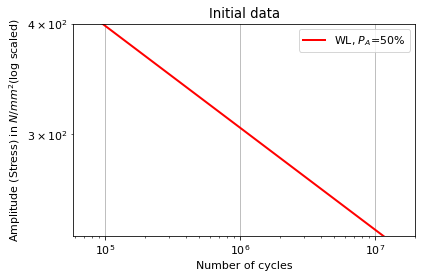

In [15]:
#pdb.set_trace()
fig, ax = plt.subplots()
PlotWC.plot_woehler_curve(ax)

ax.set_title('Initial data')
ax.set_xlim(xlim_WL)
ax.set_ylim(ylim_WL)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of cycles', fontsize = 11)
ax.set_ylabel(amp + ' (' + ld_typ+') in ' + unit + '(log scaled)')
ax.legend(loc='upper right', fontsize=11)
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 11})

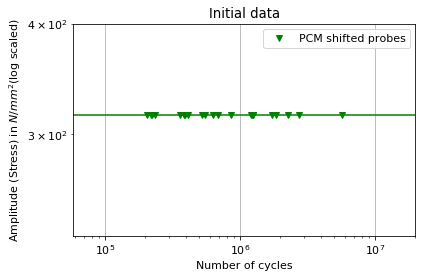

In [16]:
fig, ax = plt.subplots()
PlotWC.plot_pearl_chain_method(ax)

ax.set_title('Initial data')
ax.set_xlim(xlim_WL)
ax.set_ylim(ylim_WL)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of cycles', fontsize = 11)
ax.set_ylabel(amp + ' (' + ld_typ+') in ' + unit + '(log scaled)')
ax.legend(loc='upper right', fontsize=11)
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 11})

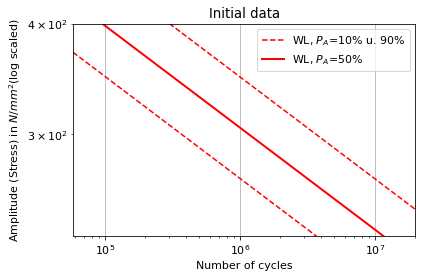

In [17]:
fig, ax = plt.subplots()
PlotWC.plot_deviation(ax).plot_woehler_curve(ax)

ax.set_title('Initial data')
ax.set_xlim(xlim_WL)
ax.set_ylim(ylim_WL)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of cycles', fontsize = 11)
ax.set_ylabel(amp + ' (' + ld_typ+') in ' + unit + '(log scaled)')
ax.legend(loc='upper right', fontsize=11)
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 11})

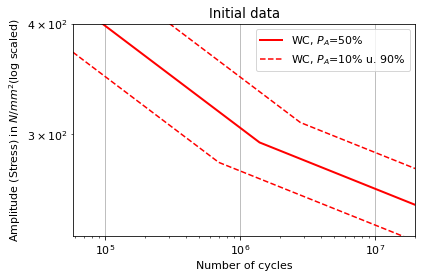

In [18]:
fig, ax = plt.subplots()
#PlotWC.plot_whole_woehler_curve_graph(0, ax)
#PlotWC.plot_whole_woehler_curve_graph(woehler_curve.k, ax)
PlotWC.plot_whole_woehler_curve_graph(2*woehler_curve.k-1, ax)
ax.set_title('Initial data')
ax.set_xlim(xlim_WL)
ax.set_ylim(ylim_WL)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Number of cycles', fontsize = 11)
ax.set_ylabel(amp + ' (' + ld_typ+') in ' + unit + '(log scaled)')
ax.legend(loc='upper right', fontsize=11)
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 11})

In [19]:
w4 = WoehlerWidget.results_visual_probability_plot()
print('Choose a plot type and execute the following cell to visualize the results:')
w4

Choose a plot type and execute the following cell to visualize the results:


RadioButtons(description='Plot Type', options=(('Probability plot of the finite zone', 'Probability plot of th…

In [20]:
#probability_plot_creator = ProbabilityPlotCreator(fatigue_data)
#probability_plot = probability_plot_creator.maximum_like_procedure(fixed_param)

### Final Woehler-curve plot
#### 7. Plot of the complete Woehler curve.
#### Choose the value of $k_2$ to plot the figure.

In [21]:
k_1 = woehler_curve.curve_parameters['k_1']
w5 = WoehlerWidget.inf_plot(woehler_curve, k_1)
print('Choose a value for k_2:')
w5

Choose a value for k_2:


RadioButtons(description='runout-zone plot', options=(('k_2 = 0', 0), ('k_2 = k_1', 8.664596198055607), ('k_2 …

### 8. Choose the parameters to plot
- Probit: $k_{regression}$, $\frac{1}{T_N}$, $ND_{50}$, $SD_{50}$(Probit),$\frac{1}{T_S}$(Probit)
- Mali: Maximum likelihood parameters (including the parameters fixed by the user)

In [22]:
w2 = WoehlerWidget.method_mali_probit()
w2

RadioButtons(description='Visualization', options=('Mali', 'Probit'), style=DescriptionStyle(description_width…

In [23]:
if len(woehler_curve.fatigue_data.ld_lvls_inf[0])<2 and w2.value == "Probit":
    print("Warning:\n")
    print("Not enough load levels in the infinite zone for the probit method, please choose the Mali")
    print("\nparameters for visualization")
else:
    SD50, ND50, TS = PlotWC.runout_zone_method(woehler_curve, method=w2.value, slope_chosen=w5.value)
    _ = PlotWC.final_curve_plot(woehler_curve, SD50, ND50, TS, w5.value, w2.value, amp, ld_typ, unit, xlim_WL, ylim_WL, default)

AttributeError: 'PlotWoehlerCurveData' object has no attribute 'runout_zone_method'

## BIC
#### Bayesian Information Criterion: is a criterion for model selection among a finite set of models;
#### the model with the lowest BIC is preferred.

In [ ]:
sum_lolli = woehler_curve_creator.mali_sum_lolli(woehler_curve.curve_parameters['SD_50'], woehler_curve.curve_parameters['1/TS'], 
                                        woehler_curve.curve_parameters['k_1'], woehler_curve.curve_parameters['ND_50'], 
                                        woehler_curve.curve_parameters['1/TN'], woehler_curve.fatigue_data.fractures,
                                        woehler_curve.fatigue_data.zone_inf, woehler_curve.fatigue_data.load_cycle_limit)

n_data_pt = data.shape[0]
bic = WC_data.bayes_inf_crit(sum_lolli, WC_data.p_opt, n_data_pt)
print('\nBIC =',bic)

## Export variable data

In [ ]:
with open('param_dict.json', 'w') as fp:
    json.dump({'Mali_%dp_result_estimated'%len(WC_data.p_opt):estim_param, 
               'Mali_%dp_result_fixed'%len(WC_data.p_opt):fixed_param,
               'Mali_2p_result':WC_data.Mali_2p_result,
               'Probit_result':WC_data.Probit_result, 'k_reg': WC_data.k, '1/TN prl-chn':WC_data.TN,
               'BIC':bic}, fp)

## Reload variable data

In [ ]:
with open('param_dict.json', 'r') as fp:
    dict_import = json.load(fp)
dict_import